In [2]:
import time
import numpy as np
import tensorflow as tf
import pandas as pd


from user import User
from average import Average
from tensorflow import keras

from graphing import *
from file_related import *
from inits import *
SEED = 0

# import os
# os.environ['PYTHONHASHSEED']=str(SEED)
# np.random.seed(SEED)
# import random
# random.seed(SEED)
# tf.set_random_seed(SEED)
# could need to force keras to not use parallelism, see documentation

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
def train_users(users, epochs,
                new_weights = None,
                train_user_verbose_evaluate = 0,
                train_user_verbose_fit = False,
                verbose = True):
    """
    this method is used to train all users on the passed in epochs value
    """
    
    for user in users.values():
        # if user.get_id() < 0:
        #     continue

        if verbose:
            message = f"User {user.get_id()} being trained on the model..."
            print(message)

        user.train(
            epochs = epochs,
            weights = new_weights, # if none, then wont be updated
            verbose_fit = train_user_verbose_fit,
            verbose_evaluate = train_user_verbose_evaluate
        )

        if verbose:
            message = f"User {user.get_id()} done!"
            print(message)

    return



def train_fed(epochs, rounds, users,
              verbose = True,
              strat = "central",
              train_user_verbose = False,
              train_user_verbose_evaluate = False,
              train_user_verbose_fit = False,
              averaging_method = Average.all,
             averaging_pre = False,
             averaging_post = False,
             averaging_metric = "accuracy"):
    """
    this function trains a federation of users using 'strat' stratergy
    central or personalised
    
    central is where all the users send data to a server and the server
    sends back new weights
    
    personalised is where all the users are sent each others data
    and the user tests how their own test data performs on everyone 
    elses models. Based on their policy, they then decide what way
    to average the data.
    """
    new_weights = None
    
    for i in range(rounds):
        
        # users' weights will not be updated till round i+1
        
        if verbose:
            message = f"{'*'*32} {i:^4} {'*'*32}"
            print(message)

        train_users(users = users, epochs = EPOCHS,
                   new_weights = new_weights,
                   verbose = train_user_verbose,
                   train_user_verbose_evaluate = train_user_verbose_evaluate,
                   train_user_verbose_fit = train_user_verbose_fit)
        if strat == "central":
            # calc new weight and pass it to train users 
            # in next round for the users to update their
            # model and retrain on their local train data
            new_weights = averaging_method(users = users, 
                                  pre = averaging_pre,
                                  post = averaging_post, 
                                  metric = averaging_metric)
    
        elif strat == "personalised":
            new_weights = dict()
            for user in users.values():
                # gather everyones models/weights in a dict
                # and pass it to train users in next round
                new_weights[user.get_id()] = user.get_weights()
            
        if verbose:
            message = f"{'*'*32} {'DONE':^4} {'*'*32}"
            print(message)
    return


In [4]:
# SEED = 0
df = read_file("../dataset/allUsers.lcl.csv")
df = shuffle_df(df, SEED)
averaging_methods = [Average.all,Average.std_dev,Average.weighted_avg]
# df.head()

In [5]:
DEVICE = '/cpu:0'
ROUNDS = 64
EPOCHS = 16 # 16 is good

In [ ]:
# forces tensorfor to the a particular device to run things
with tf.device(DEVICE):
#     averaging_methods = [Average.all]
#      # return a dictionary of users with data
    users_all, global_user = init_users(df = df, 
                                        averaging_methods = averaging_methods, 
                                        seed = SEED)
    train_fed(users = users_all, rounds = ROUNDS,
              epochs = EPOCHS,
              strat = "central",
              train_user_verbose = False,
              train_user_verbose_evaluate = False,
              train_user_verbose_fit = False,
              averaging_method = Average.all,
              averaging_post = True,
              averaging_metric = "accuracy")
    
    # return a dictionary of users with data
#     users_all_2, global_user = init_users(df = df, 
#                                         averaging_methods = averaging_methods, 
#                                         seed = SEED)
#     train_fed(users = users_all_2, rounds = ROUNDS,
#               epochs = EPOCHS,
              
#               strat = "personalised",
#               train_user_verbose = False,
#               train_user_verbose_evaluate = False,
#               train_user_verbose_fit = False,
#               averaging_post = True,
#               averaging_metric = "accuracy")
    
    
    
#     print("Global user training and validation")
#     global_user.train(epochs = EPOCHS*ROUNDS,
#        verbose_fit = False,
#        verbose_evaluate = False,
#     )

In [10]:
#     print(global_user.get_history_metrics())
    draw_graphs(users_all[7])


Initialising User instances...
0.49999999999999994
(78096, 38) (26032, 36) (26032, 36) (26032, 36)
0.49999999999999994
(9049, 38) (3016, 36) (3017, 36) (3016, 36)
0.49999999999999994
(4717, 38) (1572, 36) (1573, 36) (1572, 36)
0.49999999999999994
(4513, 38) (1504, 36) (1505, 36) (1504, 36)
User 3 has no data, no instance created...
0.49999999999999994
(379, 38) (126, 36) (127, 36) (126, 36)
0.49999999999999994
(5105, 38) (1701, 36) (1702, 36) (1702, 36)
0.49999999999999994
(4377, 38) (1459, 36) (1459, 36) (1459, 36)
0.49999999999999994
(492, 38) (164, 36) (164, 36) (164, 36)
0.49999999999999994
(6811, 38) (2270, 36) (2271, 36) (2270, 36)
0.49999999999999994
(3920, 38) (1306, 36) (1307, 36) (1307, 36)
0.49999999999999994
(9573, 38) (3191, 36) (3191, 36) (3191, 36)
0.49999999999999994
(8061, 38) (2687, 36) (2687, 36) (2687, 36)
0.49999999999999994
(4865, 38) (1621, 36) (1622, 36) (1622, 36)
0.49999999999999994
(8739, 38) (2913, 36) (2913, 36) (2913, 36)
13 User instances and a global use

In [7]:
with tf.device(DEVICE):
    averaging_methods = [Average.std_dev]
    # return a dictionary of users with data
    users_std_dev, global_user = init_users(df = df, 
                                        averaging_methods = averaging_methods, 
                                        seed = SEED)
    train_fed(users = users_std_dev, rounds = ROUNDS,
              epochs = EPOCHS,
              strat = "central",
              train_user_verbose = False,
              train_user_verbose_evaluate = False,
              train_user_verbose_fit = False,
              averaging_method =  Average.std_dev,
             averaging_post = True,
              averaging_metric = "accuracy")
    
    # return a dictionary of users with data
    users_std_dev_2, global_user = init_users(df = df, 
                                        averaging_methods = averaging_methods, 
                                        seed = SEED)
    train_fed(users = users_std_dev_2, rounds = ROUNDS,
              epochs = EPOCHS,
              strat = "personalised",
              train_user_verbose = False,
              train_user_verbose_evaluate = False,
              train_user_verbose_fit = False,
              averaging_post = True,
              averaging_metric = "accuracy")
    
    

Initialising User instances...
User 3 has no data, no instance created...
13 User instances and a global user created!
********************************  0   ********************************
User 4: 0.8140161633491516 < 0.8451234004204193
User 7: 0.6307054162025452 < 0.8451234004204193
******************************** DONE ********************************
********************************  1   ********************************


KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

In [ ]:
with tf.device(DEVICE):
    averaging_methods = [Average.weighted_avg]
    
    # return a dictionary of users with data
    users_weighted_avg, global_user = init_users(df = df, 
                                        averaging_methods = averaging_methods, 
                                        seed = SEED)
    train_fed(users = users_weighted_avg, rounds = ROUNDS,
              epochs = EPOCHS,
              strat = "central",
              train_user_verbose = False,
              train_user_verbose_evaluate = False,
              train_user_verbose_fit = False,
              averaging_method = Average.weighted_avg,
              averaging_post = True,
              averaging_metric = "accuracy")
    
    # return a dictionary of users with data
    users_weighted_avg_2, global_user = init_users(df = df, 
                                        averaging_methods = averaging_methods, 
                                        seed = SEED)
    train_fed(users = users_weighted_avg_2, rounds = ROUNDS,
              epochs = EPOCHS,
              strat = "personalised",
              train_user_verbose = False,
              train_user_verbose_evaluate = False,
              train_user_verbose_fit = False,
              averaging_post = True,
              averaging_metric = "accuracy")
    

All
For central
Final values for Pre-fit accuracy
Position                   Pre
Round                       63
Average               0.743287
Standard Deviation    0.175409
Minimum               0.467613
Maximum               0.966371
Name: 126, dtype: object
Final values for Post-fit accuracy
Position                   Post
Round                        63
Average                0.990455
Standard Deviation    0.0266038
Minimum                0.900415
Maximum                       1
Name: 127, dtype: object



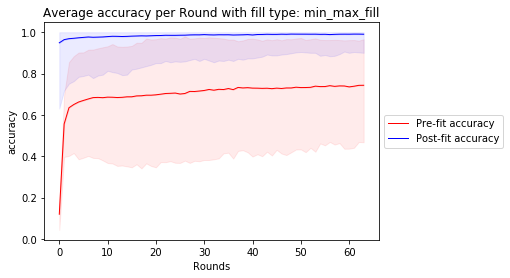

Final accuracy for Pre-fit data
   User  Final Value
1     0     0.713351
3     1     0.625703
5     2     0.623700
7     4     0.522911
9     5     0.467613
11    6     0.867568
13    7     0.481328
15    8     0.843123
17    9     0.814111
19   10     0.823918
21   11     0.965063
23   12     0.947976
25   13     0.966371
Averaged: 0.7432873615851769

Final accuracy for Post-fit data
   User  Final Value
0     0     0.999211
2     1     1.000000
4     2     0.999548
6     4     0.978437
8     5     0.999800
10    6     1.000000
12    7     0.900415
14    8     1.000000
16    9     1.000000
18   10     0.998508
20   11     1.000000
22   12     1.000000
24   13     1.000000
Averaged: 0.9904552193788382



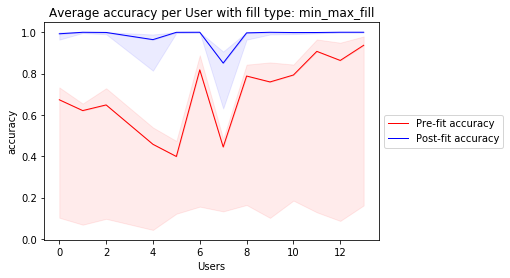

<Figure size 432x288 with 0 Axes>

In [15]:
ignore_first_n = 0
final_values = True



print("All")

# print("For p2p")


# df_avg_round_stats_acc = avg_round_stats(users_all_2, 
#                                          ignore_first_n = ignore_first_n, 
#                                          min_max_fill = True, 
#                                          metric = "accuracy",
#                                          final_values = final_values)
# df_avg_user_stats_acc = avg_user_stats(users_all_2, 
#                                        ignore_first_n = ignore_first_n, 
#                                        min_max_fill = True, 
#                                        metric = "accuracy",
#                                        final_values = final_values)
print("For central")


df_avg_round_stats_acc = avg_round_stats(users_all, 
                                         ignore_first_n = ignore_first_n, 
                                         min_max_fill = True, 
                                         metric = "accuracy",
                                         final_values = final_values)
df_avg_user_stats_acc = avg_user_stats(users_all, 
                                       ignore_first_n = ignore_first_n, 
                                       min_max_fill = True, 
                                       metric = "accuracy",
                                       final_values = final_values)

In [ ]:
ignore_first_n = 0
final_values = True

print("Std deviation")

print("For p2p")


df_avg_round_stats_acc = avg_round_stats(users_std_dev_2, 
                                         ignore_first_n = ignore_first_n, 
                                         min_max_fill = True, 
                                         metric = "accuracy",
                                         final_values = final_values)
df_avg_user_stats_acc = avg_user_stats(users_std_dev_2, 
                                       ignore_first_n = ignore_first_n, 
                                       min_max_fill = True, 
                                       metric = "accuracy",
                                       final_values = final_values)
print("For central")


df_avg_round_stats_acc = avg_round_stats(users_std_dev, 
                                         ignore_first_n = ignore_first_n, 
                                         min_max_fill = True, 
                                         metric = "accuracy",
                                         final_values = final_values)
df_avg_user_stats_acc = avg_user_stats(users_std_dev, 
                                       ignore_first_n = ignore_first_n, 
                                       min_max_fill = True, 
                                       metric = "accuracy",
                                       final_values = final_values)

print(users_std_dev[1].get_history_metrics())
draw_graphs(users_std_dev[1])

In [ ]:
ignore_first_n = 0
final_values = True

print("Weighted average")

print("For p2p")


df_avg_round_stats_acc = avg_round_stats(users_weighted_avg_2, 
                                         ignore_first_n = ignore_first_n, 
                                         min_max_fill = True, 
                                         metric = "accuracy",
                                         final_values = final_values)
df_avg_user_stats_acc = avg_user_stats(users_weighted_avg_2, 
                                       ignore_first_n = ignore_first_n, 
                                       min_max_fill = True, 
                                       metric = "accuracy",
                                       final_values = final_values)
print("For central")


df_avg_round_stats_acc = avg_round_stats(users_weighted_avg, 
                                         ignore_first_n = ignore_first_n, 
                                         min_max_fill = True, 
                                         metric = "accuracy",
                                         final_values = final_values)
df_avg_user_stats_acc = avg_user_stats(users_weighted_avg, 
                                       ignore_first_n = ignore_first_n, 
                                       min_max_fill = True, 
                                       metric = "accuracy",
                                       final_values = final_values)